In [141]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [142]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2019-01-01', end='2023-12-31', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[                       0%%                      ]

[*********************100%%**********************]  8 of 8 completed


,ds,unique_id,y
0,2019-02-01,AAPL,0.039523
1,2019-03-01,AAPL,0.096882
2,2019-04-01,AAPL,0.054901
3,2019-05-01,AAPL,-0.136476
4,2019-06-01,AAPL,0.126520
...,...,...,...
467,2023-08-01,NVDA,0.054674
468,2023-09-01,NVDA,-0.126301
469,2023-10-01,NVDA,-0.064464
470,2023-11-01,NVDA,0.137050


In [143]:
season_length = 12
horizon = 3

models = [
    Naive(),
    AutoETS(season_length=season_length),
    AutoTheta(season_length=season_length),
    AutoARIMA(season_length=season_length),
    SeasonalNaive(season_length=season_length),
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='MS',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [144]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,AutoETS,AutoTheta,AutoARIMA,SeasonalNaive
unique_id,,,,,,
AAPL,2024-01-01,0.014808,0.026714,0.011821,0.021517,0.104829
AAPL,2024-02-01,0.014808,0.026714,0.011401,0.004391,0.021393
AAPL,2024-03-01,0.014808,0.026714,0.010980,0.023327,0.113647
AMZN,2024-01-01,0.039263,0.009602,0.018290,0.000000,0.205174
AMZN,2024-02-01,0.039263,0.009602,0.018145,0.000000,-0.090252


In [145]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=3, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-90,Naive-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,,,,,,,,,
AAPL,2023-04-01,2023-03-01,0.028575,0.113647,-0.091753,0.319047,0.028183,-0.123828,0.180195,0.009413,-0.131895,0.187647,-0.027686,-0.176514,0.121141,-0.102178,-0.286837,0.082481
AAPL,2023-05-01,2023-03-01,0.043647,0.113647,-0.176832,0.404127,0.028183,-0.123828,0.180195,0.008845,-0.154216,0.143630,-0.015582,-0.164409,0.133245,-0.057505,-0.242164,0.127154
AAPL,2023-06-01,2023-03-01,0.091525,0.113647,-0.242116,0.469410,0.028183,-0.123828,0.180195,0.008276,-0.185938,0.159627,-0.022617,-0.171444,0.126210,-0.083469,-0.268128,0.101190
AAPL,2023-07-01,2023-06-01,0.012704,0.091525,-0.109131,0.292181,0.029826,-0.118229,0.177880,0.024036,-0.114078,0.198241,0.000000,-0.150537,0.150537,0.172804,-0.015419,0.361028
AAPL,2023-08-01,2023-06-01,-0.044658,0.091525,-0.192246,0.375295,0.029826,-0.118229,0.177880,0.023806,-0.135384,0.155069,0.000000,-0.150537,0.150537,-0.033093,-0.221317,0.155130


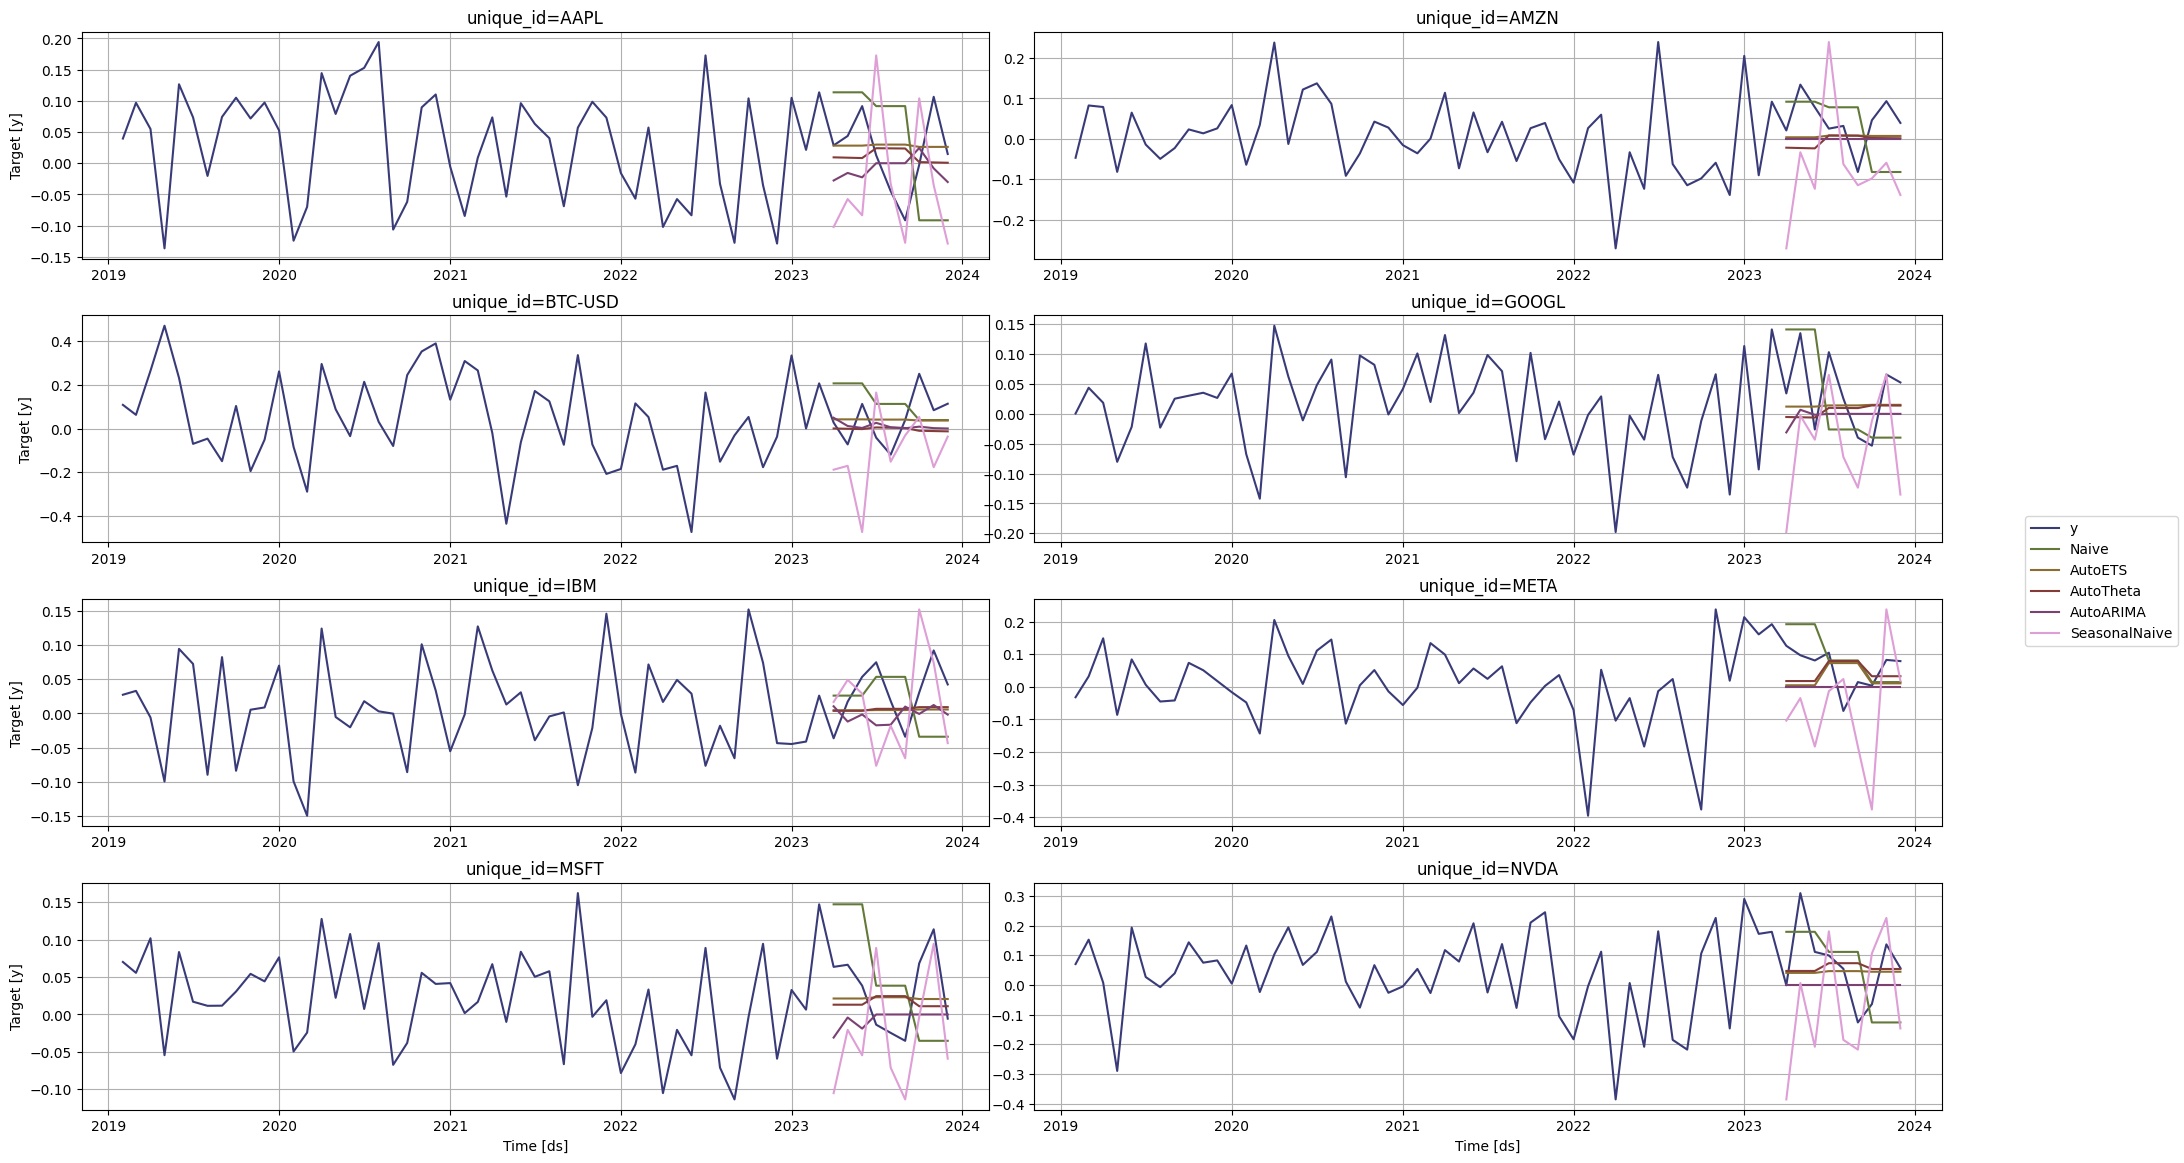

In [146]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))

In [147]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [148]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [149]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [150]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [151]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-16 14:09:38,174 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5a514fd76892121919eae33176c3f610 initialized by task ('shuffle-transfer-5a514fd76892121919eae33176c3f610', 4) executed on worker tcp://127.0.0.1:55968
2024-07-16 14:09:42,535 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5a514fd76892121919eae33176c3f610 deactivated due to stimulus 'task-finished-1721131782.526769'


,unique_id,cutoff,metric,Naive,AutoETS,AutoTheta,AutoARIMA,SeasonalNaive
0,AAPL,2023-06-01,mse,0.01942,0.006854,0.00602,0.00351,0.009022
1,AAPL,2023-06-01,mae,0.132679,0.07098,0.06496,0.049624,0.069237
2,AAPL,2023-06-01,smape,183.748108,160.171158,153.894653,200.0,78.420685
3,GOOGL,2023-06-01,mse,0.006537,0.00366,0.003796,0.004301,0.006005
4,GOOGL,2023-06-01,mae,0.064943,0.051513,0.052831,0.056231,0.073151


In [152]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive     AutoETS   AutoTheta   AutoARIMA  \
cutoff     metric                                                   
2023-03-01 mae       0.090087     0.06508    0.071266    0.082338   
           mse       0.012033    0.007454    0.008078    0.010365   
           smape    92.514908  132.921112  159.283539  191.955963   
2023-06-01 mae       0.091578    0.061657    0.060265    0.058593   
           mse         0.0126    0.006068    0.005846    0.004702   
           smape   143.840302  144.490295  149.802338  199.419586   
2023-09-01 mae       0.106766    0.060356    0.065945    0.072533   
           mse        0.01534    0.005483    0.007258    0.007611   
           smape   164.352249  135.186752  155.048645  197.009613   

                   SeasonalNaive  
cutoff     metric                 
2023-03-01 mae           0.18533  
           mse          0.050736  
           smape      178.183304  
2023-06-01 mae          0.097938  
           mse          0.013699  
           smape      132.440872  
2023-09-01 mae          0.130567  
           mse          0.023997  
           smape      152.705429

<Axes: xlabel='error', ylabel='model'>

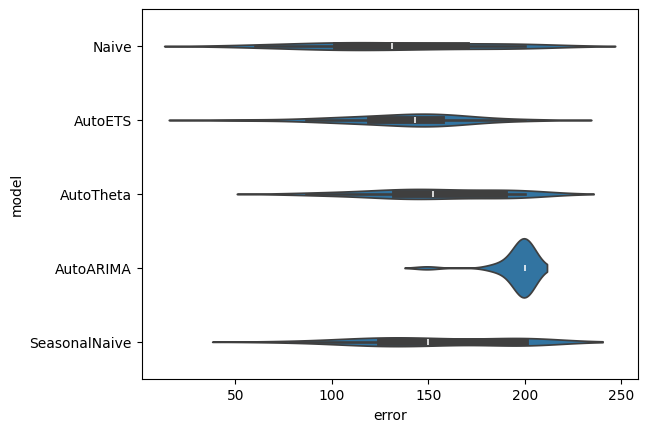

In [153]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

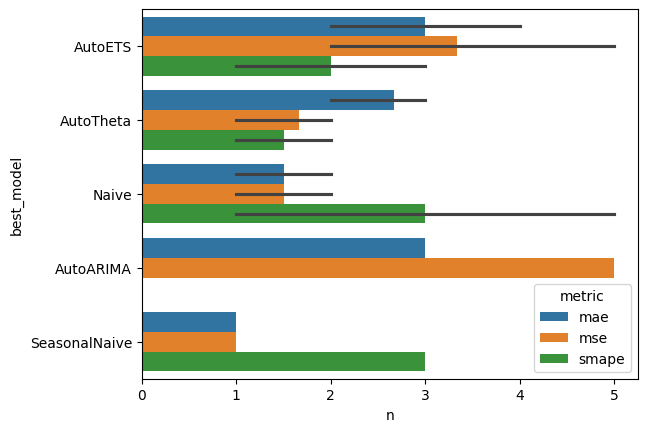

In [154]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')